In [ ]:
micromamba activate scvelo_jupyter_new
micromamba run -n scvelo_jupyter_new pip install rds2py
micromamba run -n scvelo_jupyter_new pip install twine
micromamba run -n scvelo_jupyter_new pip install git+https://github.com/furlan-lab/pyviewmaster.git
micromamba run -n scvelo_jupyter_new pip install plotly==5.24.1
micromamba run -n scvelo_jupyter_new pip install colorcet

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket
from pyviewmaster import *
import seaborn as sns
import colorcet as cc
import plotly.express as px
import matplotlib.pyplot as plt

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
  ROOT_DIR1 = "/fh/fast/furlan_s/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
  ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/patient_marrows/WC1/cds"


## LOAD SUMMARIZED EXPERIMENT OBJECT IN PYTHON

In [2]:
from rds2py import read_rds
ref =read_rds(ROOT_DIR1+"/240126_Combined_SE_Object.RDS")


In [3]:
coldata = get_coldata_rds_obj(ref)
coldata.set_index = coldata["rownames"]
rowdata = get_rowdata_rds_obj(ref)
rowdata.set_index = rowdata["gene_short_name"]
scounts = get_counts_rds_obj(ref)

In [4]:
rdata = ad.AnnData(scounts)
rdata.obs = coldata
rdata.var = rowdata
rdata.obs_names = coldata.index
rdata.var_names = rowdata.index
rdata.layers["counts"] = rdata.X.copy()

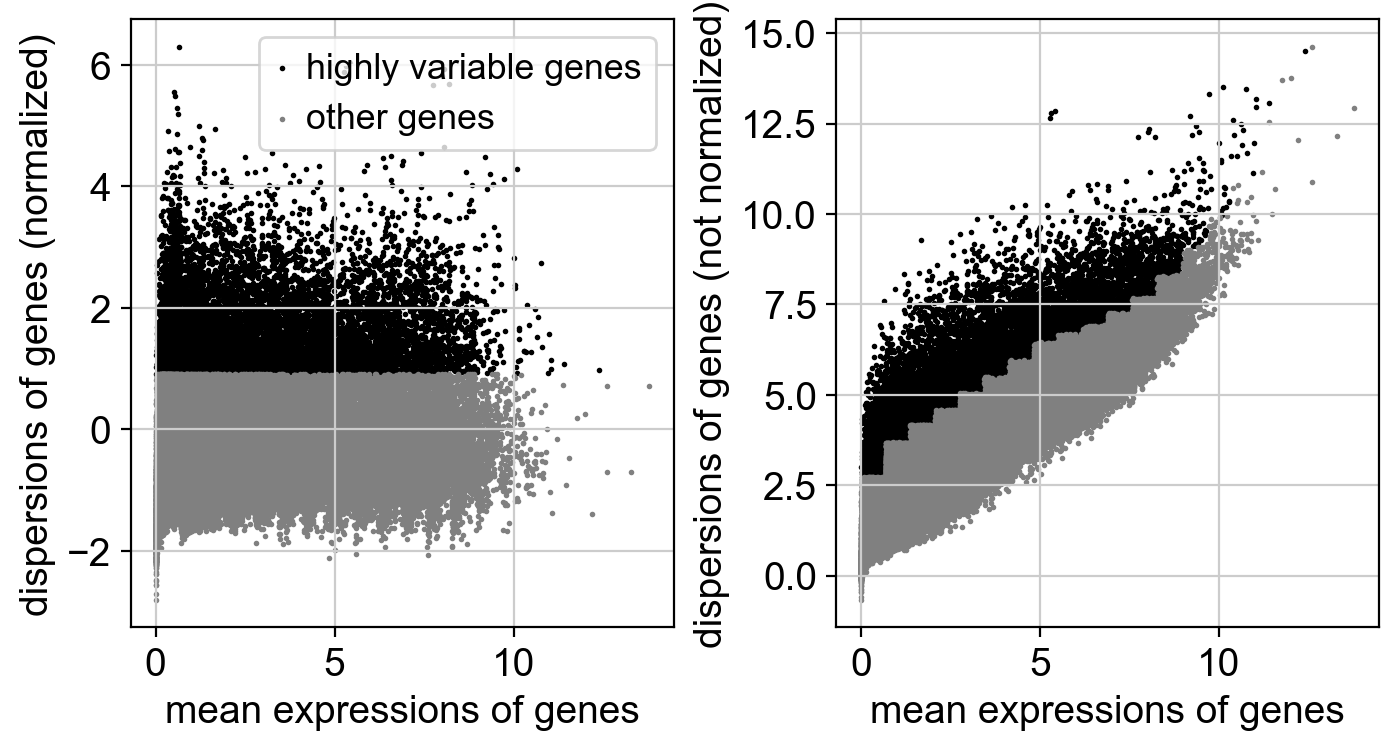

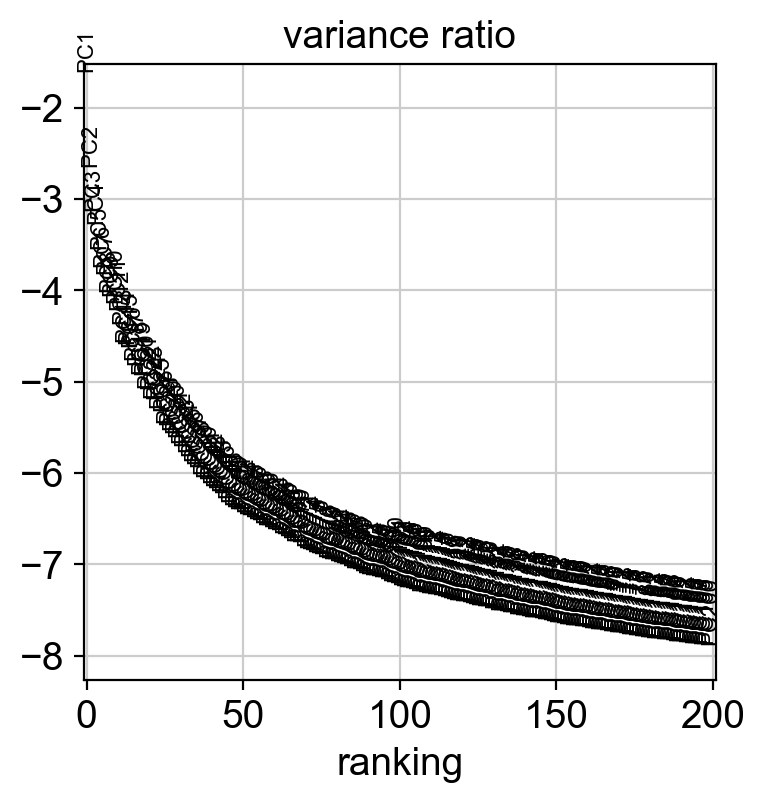

In [5]:
sc.pp.normalize_total(rdata)
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000)
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata, n_comps=200)
sc.pl.pca_variance_ratio(rdata, n_pcs=200, log=True)


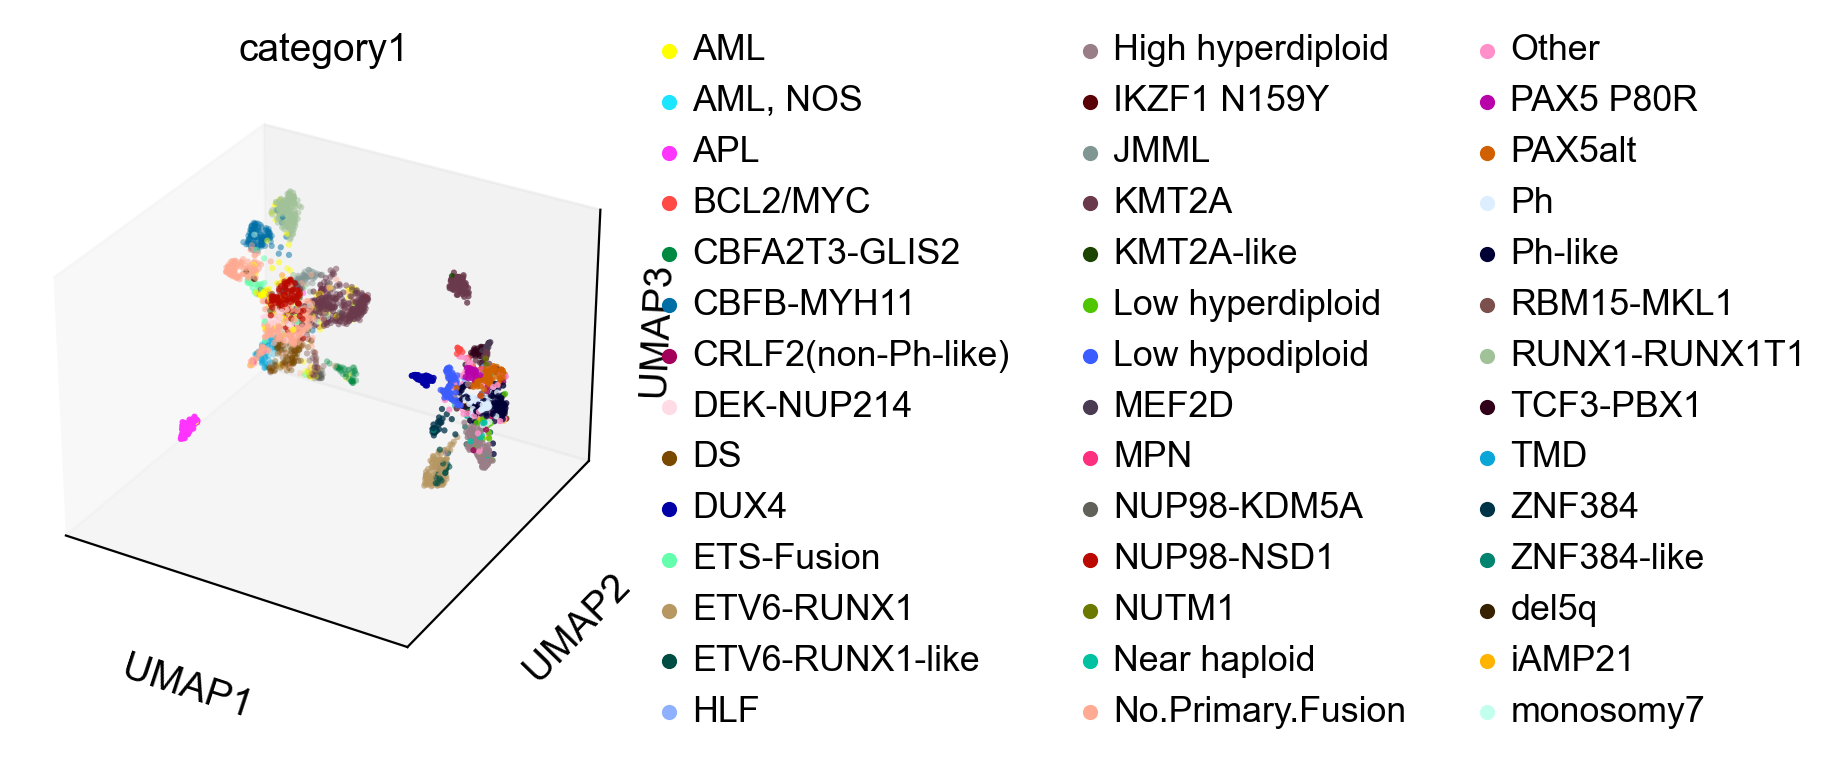

In [6]:
sc.pp.neighbors(rdata, n_pcs=200)

sc.tl.umap(rdata, min_dist=0.4, n_components=3)

sc.pl.umap(rdata, color = "category1", projection = "3d")

In [7]:
palette = sns.color_palette(cc.glasbey, n_colors=50, as_cmap=True)

In [8]:
df = rdata.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2", "umap3"]
df["category1"] = rdata.obs["category1"].values
df.index = rdata.obs.index
fig = px.scatter_3d(df, x='umap1', y='umap2', z='umap3',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()


## LOAD QUERY

In [9]:
adata = sc.read_loom(ROOT_DIR2+"/WC_velocity.loom")

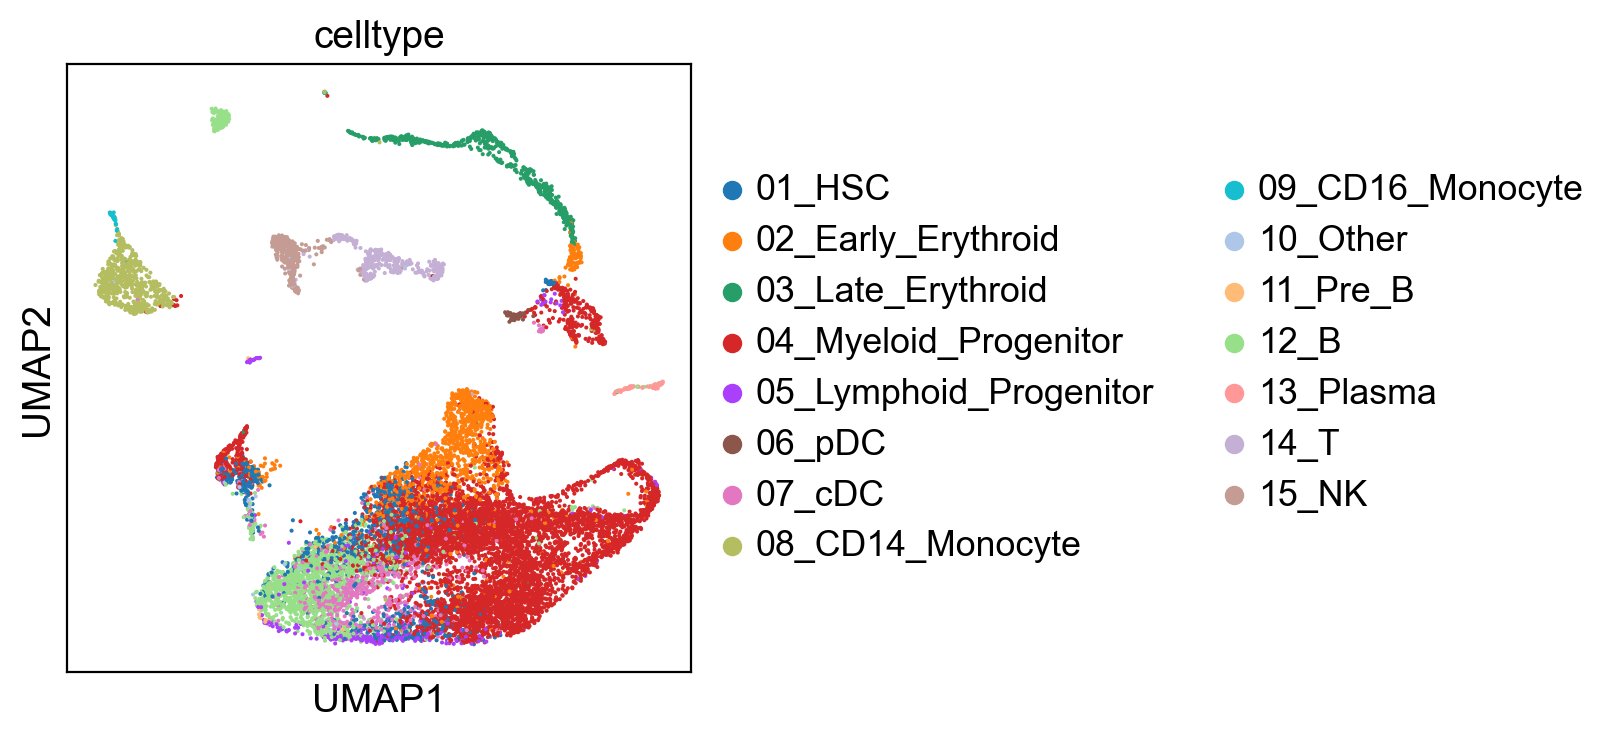

In [10]:
sc.pl.umap(adata, color = "celltype")


In [53]:
query = adata
ref = rdata
N=6
bulk_feature_row="gene_short_name"
bulk_assay_name="counts"
sc_assay_name="matrix"
dist="sc-direct"


In [54]:
import numpy as np
import pandas as pd

# Assume counts_query and sizes are already defined from earlier code
counts_query = get_counts_adata(query, layer=sc_assay_name)
sizes = sum_counts(counts_query, axis=1)
min_size = sizes.min()
max_size = sizes.max()

# Number of single cells to generate
ss_cells = N * ref.shape[0]

if dist == "sc-model":
    print("Modeling count distribution of query using Empirical CDF")
    # Sort sizes to create the CDF
    sorted_sizes = np.sort(sizes)
    cdf = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
    # Draw random samples from a uniform distribution
    uniform_samples = np.random.rand(ss_cells)
    # Use inverse transform sampling to get values that match the empirical CDF
    final_newsizes = np.interp(uniform_samples, cdf, sorted_sizes).astype(int)

else:
    # Use the direct sampling approach for "sc-direct" as before
    final_newsizes = np.random.choice(sizes, ss_cells, replace=True).astype(int)

print("Finding common features between ref and query")
genes_query = query.var_names
genes_ref = ref.var[bulk_feature_row].values
universe = np.intersect1d(genes_ref, genes_query)

if len(universe) == 0:
    raise ValueError("No common genes found between ref and query.")

print(f"Simulating {N} single cells for every bulk dataset case")

# Prepare the reference counts data
counts_ref_full = get_counts_adata(ref, layer="counts")
counts_ref_full = pd.DataFrame(counts_ref_full.todense().T)
counts_ref_full.index = genes_ref
counts_ref_full.columns = counts_ref_full.columns.astype(str)
counts_ref_full = counts_ref_full.loc[universe, :]
fdata = anndata.AnnData(counts_ref_full.T)
fdata.obs = ref.obs

Finding common features between ref and query
Simulating 6 single cells for every bulk dataset case


17874


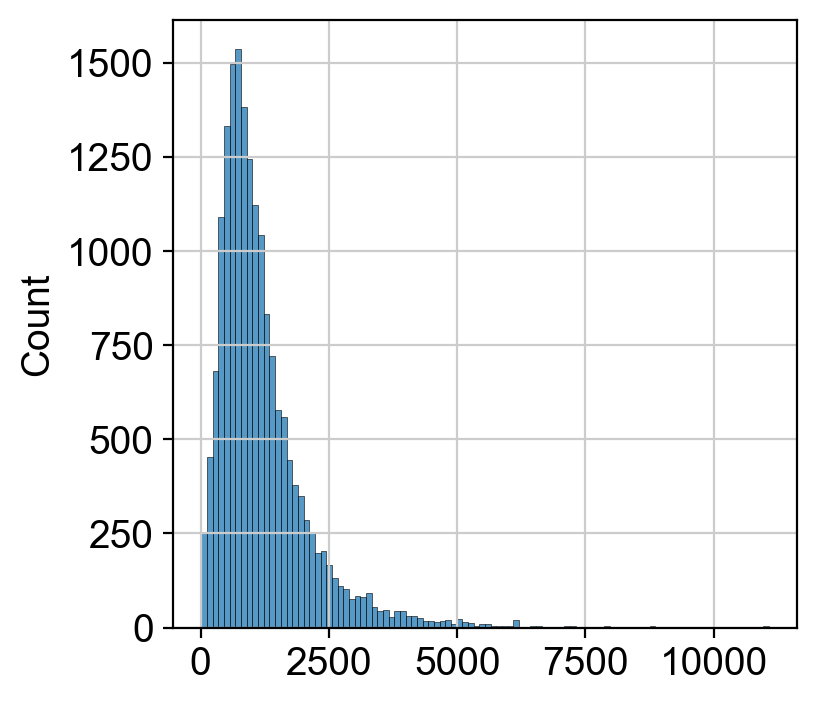

In [55]:
#sns.kdeplot(final_newsizes)
sns.histplot(final_newsizes, bins = 100)
print(len(final_newsizes))

<Axes: ylabel='Count'>

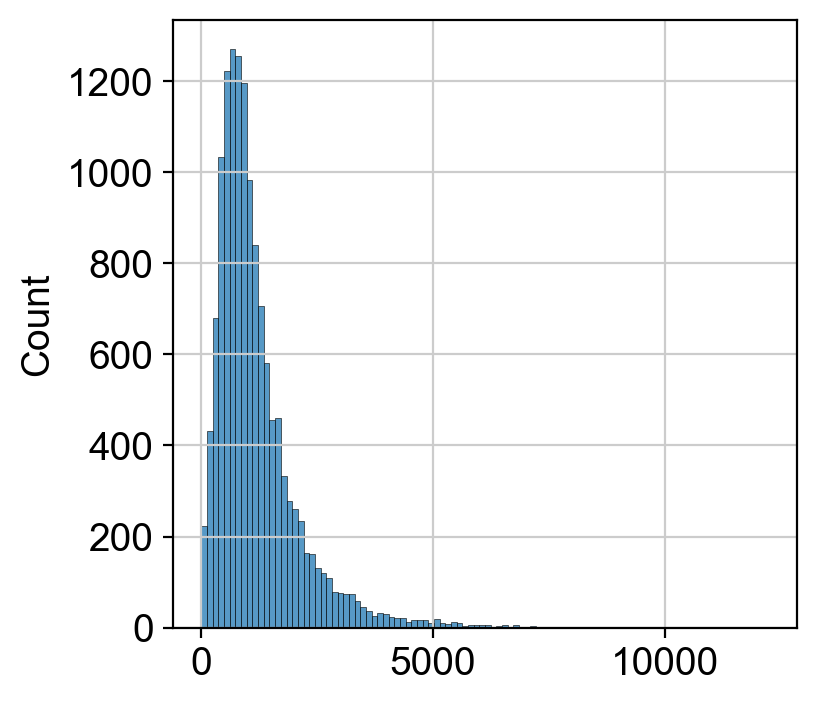

In [56]:
#sns.kdeplot(sizes)
sns.histplot(sizes, bins = 100)


In [57]:
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse

def downsample_counts_vectorized(counts_matrix, new_total_counts):
    """
    Downsamples counts for multiple cells using vectorized multinomial sampling.
    
    Parameters:
    counts_matrix (np.array): 2D array of counts (cells x genes).
    new_total_counts (np.array): 1D array of target total counts for downsampling (length = number of cells).
    
    Returns:
    np.array: Downsampled counts matrix.
    """
    # Compute total counts per cell
    original_total_counts = counts_matrix.sum(axis=1)
    
    # Avoid division by zero
    nonzero_mask = original_total_counts > 0
    
    # Compute probabilities
    probabilities = np.zeros_like(counts_matrix, dtype=float)
    probabilities[nonzero_mask] = counts_matrix[nonzero_mask] / original_total_counts[nonzero_mask, np.newaxis]
    
    # Initialize the random number generator
    rng = np.random.default_rng()
    
    # Prepare an array to hold the downsampled counts
    downsampled_counts = np.zeros_like(counts_matrix, dtype=int)
    
    # Perform multinomial sampling where both original and new total counts are greater than zero
    valid_mask = nonzero_mask & (new_total_counts > 0)
    if np.any(valid_mask):
        downsampled_counts[valid_mask] = rng.multinomial(
            n=new_total_counts[valid_mask],
            pvals=probabilities[valid_mask]
        )
    
    return downsampled_counts

def expand_anndata(adata, fold=10, total_counts_vector=None):
    """
    Expands an AnnData object to `fold` times its size by downsampling the counts
    using random sampling and total counts provided by the user. The `obs` DataFrame
    is similarly expanded.
    
    Parameters:
    adata (AnnData): The input AnnData object.
    fold (int): The factor by which to expand the data.
    total_counts_vector (np.array): 1D array of total counts for downsampled cells.
                                    Its length should be equal to `adata.n_obs * fold`.
    
    Returns:
    AnnData: A new AnnData object with the expanded data and expanded `obs`.
    """
    from scipy.sparse import issparse

    # Convert original counts to a dense matrix if sparse
    if issparse(adata.X):
        original_counts = adata.X.toarray()
    else:
        original_counts = adata.X.copy()
    
    # Get the number of original cells and genes
    num_cells, num_genes = original_counts.shape
    
    # Validate the total_counts_vector
    if total_counts_vector is not None:
        expected_length = num_cells * fold
        if len(total_counts_vector) != expected_length:
            raise ValueError(
                f"The length of total_counts_vector ({len(total_counts_vector)}) "
                f"must be equal to the number of expanded cells ({expected_length})."
            )
        # Ensure non-negative integer counts
        new_total_counts = np.maximum(np.array(total_counts_vector, dtype=int), 0)
    else:
        # Use the original total counts repeated `fold` times
        original_total_counts = original_counts.sum(axis=1)
        new_total_counts = np.tile(original_total_counts, fold)
    
    # Expand counts by repeating each cell `fold` times
    expanded_counts = np.repeat(original_counts, fold, axis=0)
    
    # Downsample counts using vectorized multinomial sampling
    downsampled_counts = downsample_counts_vectorized(expanded_counts, new_total_counts)
    
    # Expand the obs DataFrame
    expanded_obs = pd.DataFrame(
        np.repeat(adata.obs.values, fold, axis=0),
        columns=adata.obs.columns
    )
    
    # Generate replicate numbers and new observation names
    replicate_numbers = np.tile(np.arange(1, fold + 1), num_cells)
    repeated_indices = np.repeat(adata.obs_names.values, fold)
    expanded_obs_names = [
        f"{obs}_rep{rep}" for obs, rep in zip(repeated_indices, replicate_numbers)
    ]
    expanded_obs.index = expanded_obs_names
    
    # Create a new AnnData object with the downsampled counts and expanded obs
    expanded_adata = ad.AnnData(
        X=sparse.csr_matrix(downsampled_counts),
        obs=expanded_obs,
        var=adata.var.copy()
    )
    
    return expanded_adata


In [58]:
fdataf = expand_anndata(fdata, fold= 6, total_counts_vector=final_newsizes)

In [41]:
fdataf

AnnData object with n_obs × n_vars = 5958 × 35721
    obs: 'sample', 'fastq1', 'fastq2', 'output', 'software', 'index', 'gtf', 'filenames', 'category1', 'Lib_Prep', 'Primary.Fusion', 'Bone.marrow.leukemic.blast.percentage....', 'OS.time..days.', 'OS.event.ID', 'category0', 'category2', 'category3', 'all_other_data', 'final_group', 'rownames'

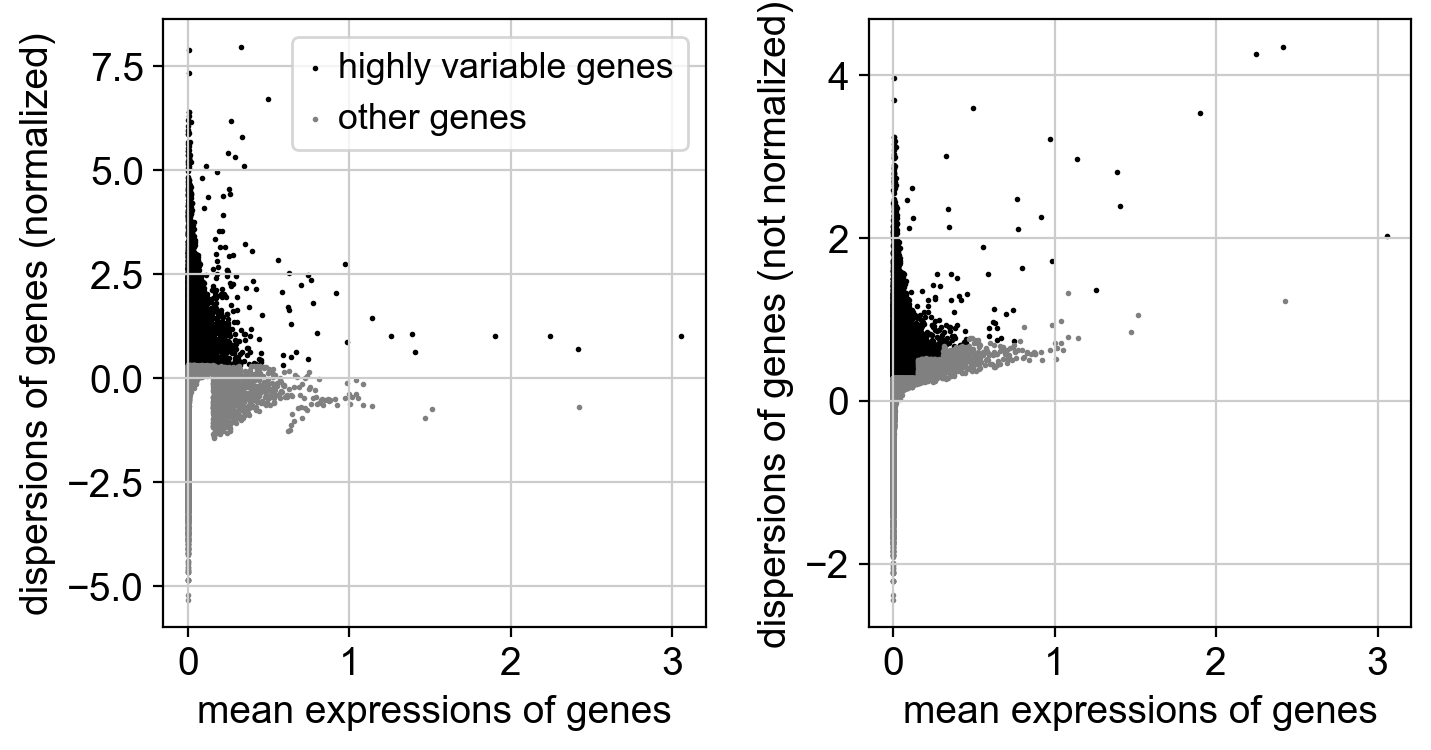

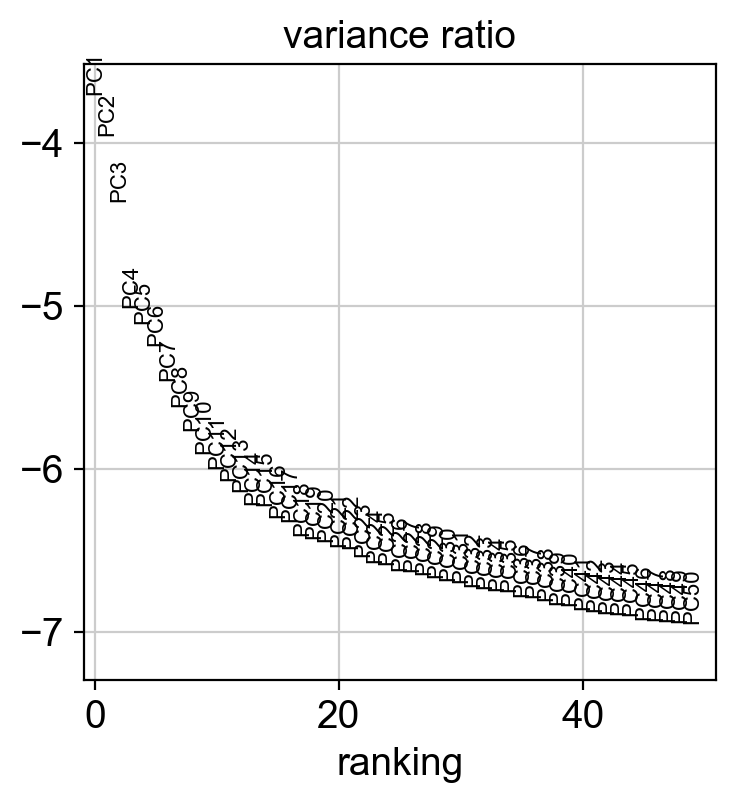

In [60]:
sc.pp.normalize_total(fdataf)
sc.pp.log1p(fdataf)
sc.pp.highly_variable_genes(fdataf, n_top_genes=10000)
sc.pl.highly_variable_genes(fdataf)
sc.tl.pca(fdataf, n_comps=50)
sc.pl.pca_variance_ratio(fdataf, n_pcs=50, log=True)

In [61]:
sc.pp.neighbors(fdataf, n_pcs=50)

sc.tl.umap(fdataf, min_dist=0.4, n_components=3)


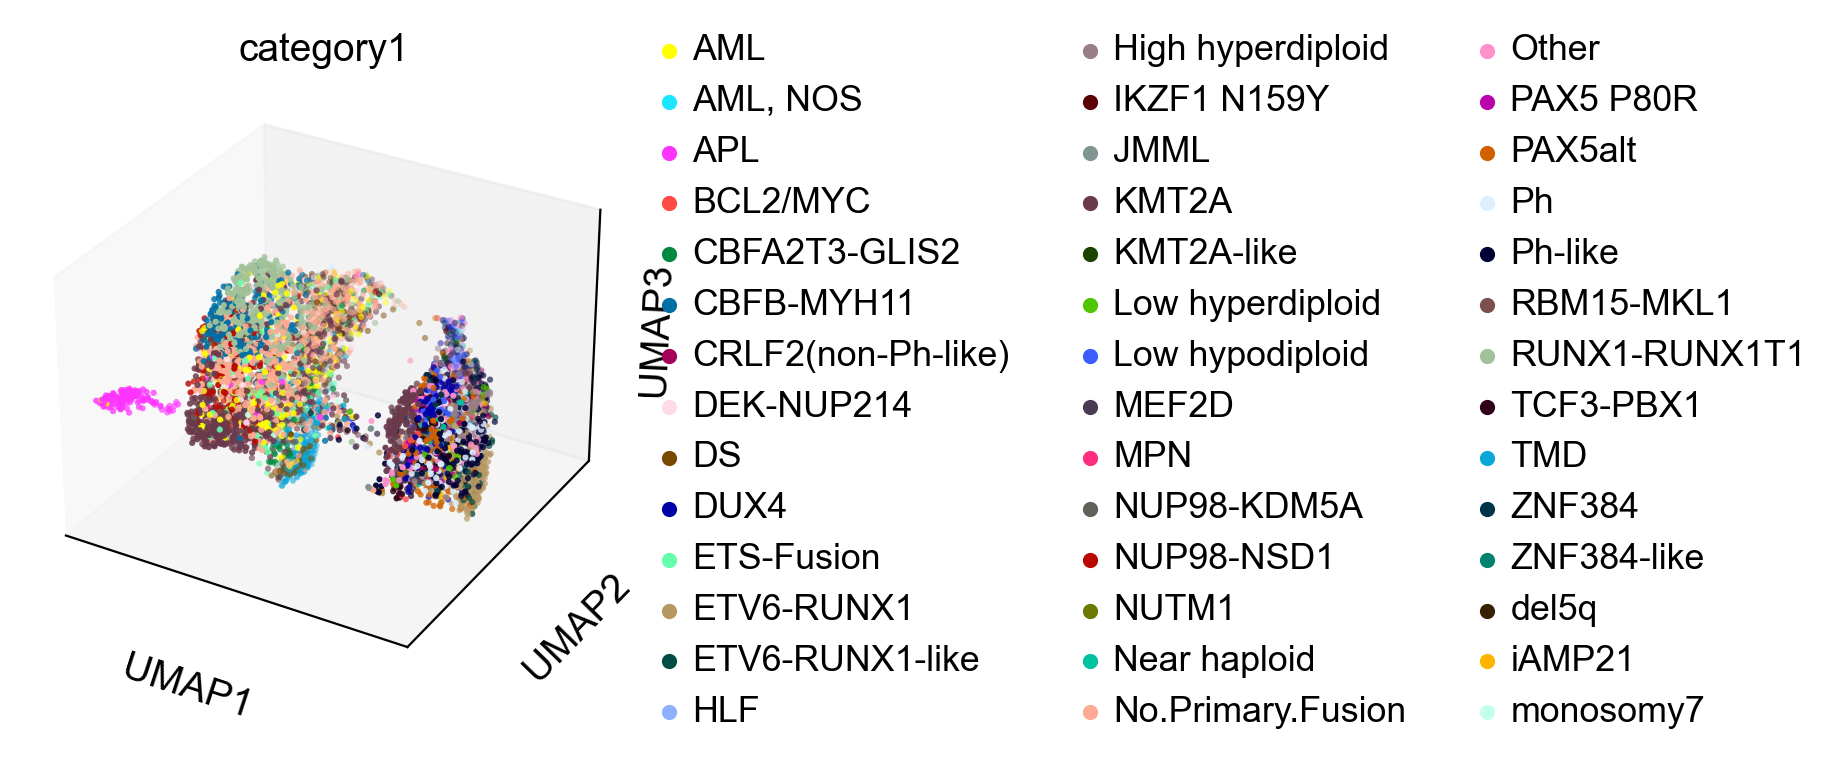

In [44]:

sc.pl.umap(fdataf, color = "category1", projection = "3d")

In [62]:
df = fdataf.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2", "umap3"]
df["category1"] = fdataf.obs["category1"].values
df.index = fdataf.obs.index
fig = px.scatter_3d(df, x='umap1', y='umap2', z='umap3',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()

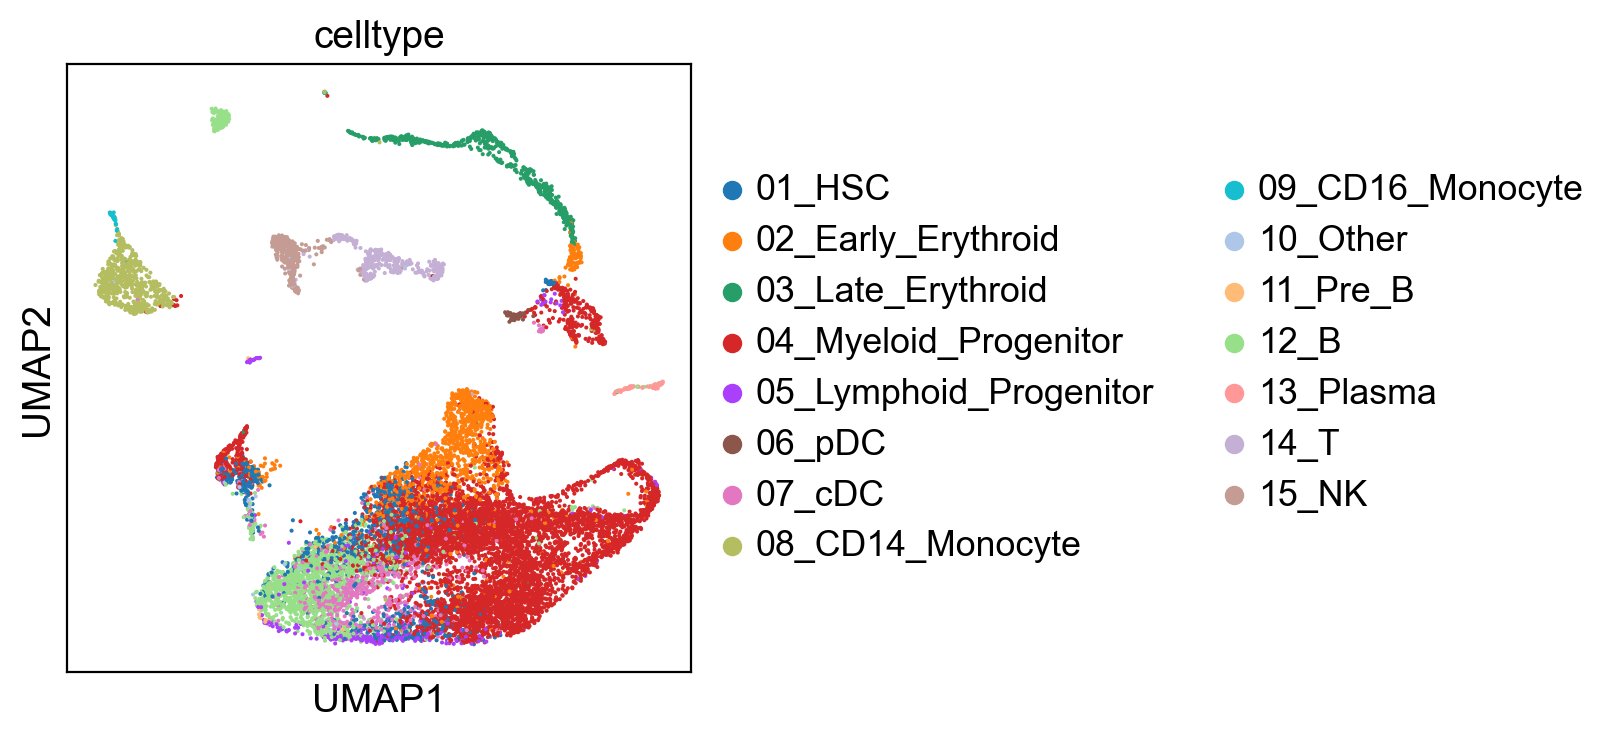

In [64]:
sc.pl.umap(query, color = "celltype")

In [65]:
viewmaster(query_cds=query, ref_cds=fdataf, ref_celldata_col="category1")

Preparing data...
Normalizing data...
Predictions added to query_cds.obs['viewmaster_pred']


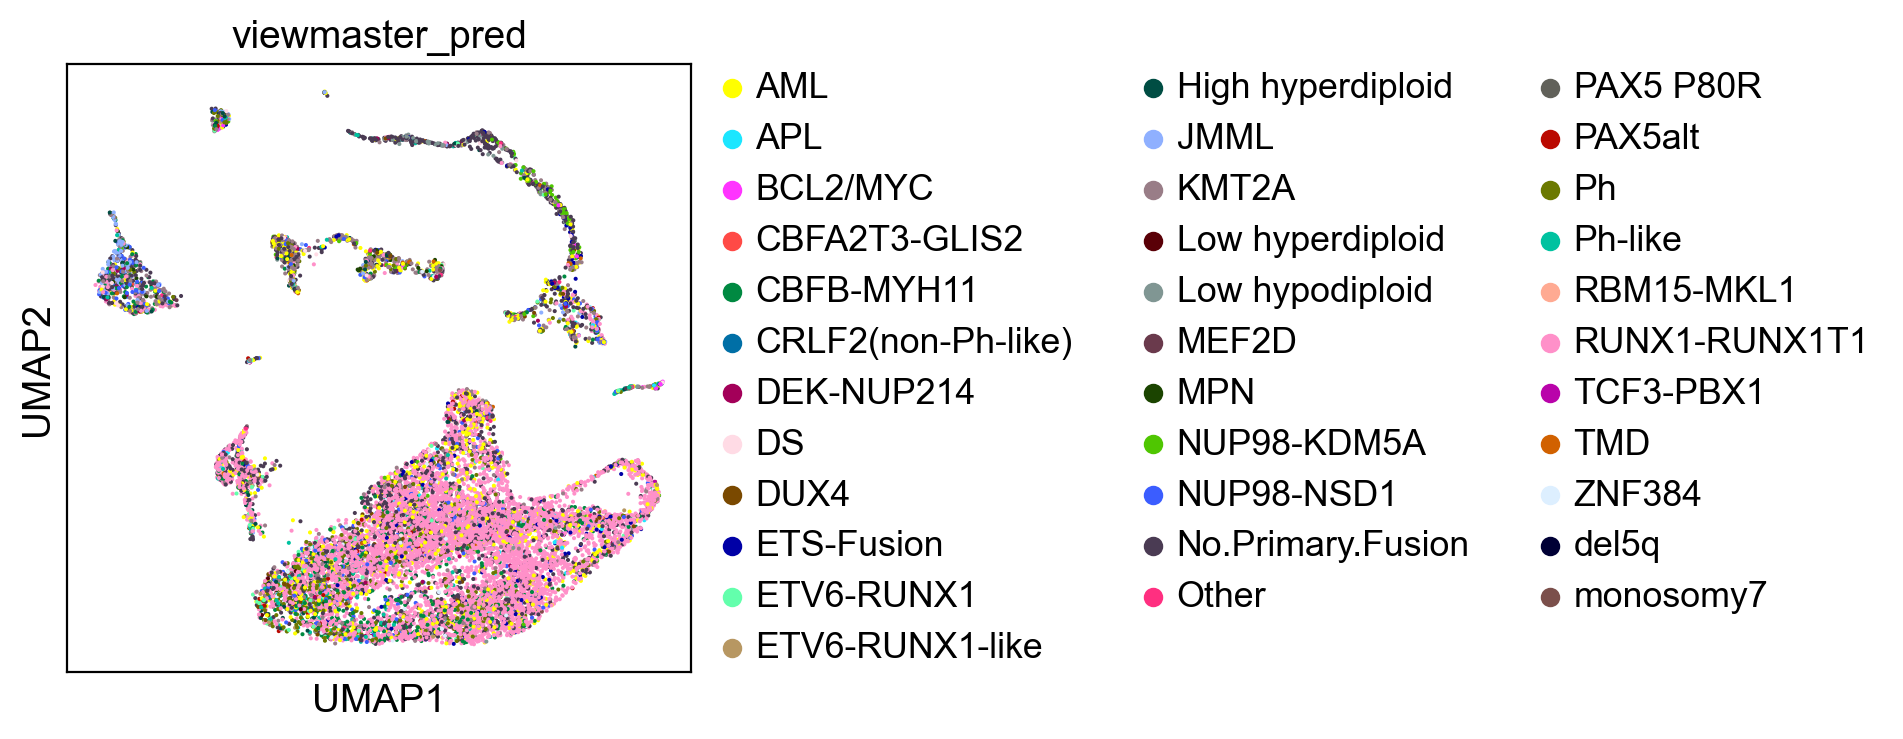

In [66]:
sc.pl.umap(query, color = "viewmaster_pred")

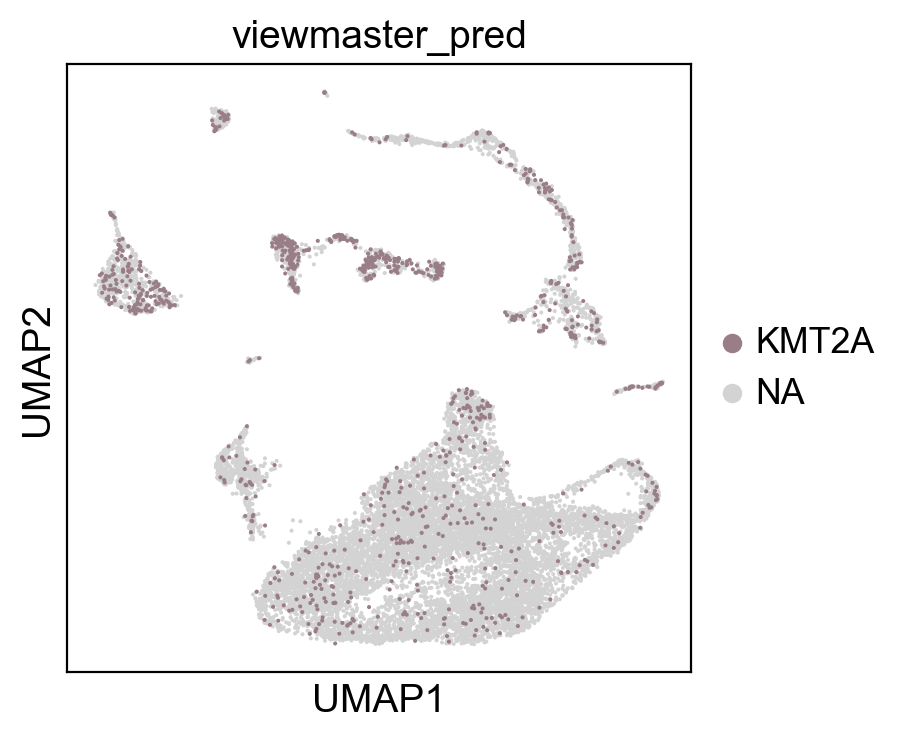

In [74]:
sc.pl.umap(query, color = "viewmaster_pred", groups = "KMT2A")

In [73]:
df = query.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2"]
df["category1"] = query.obs["viewmaster_pred"].values
df.index = query.obs.index
fig = px.scatter(df, x='umap1', y='umap2',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()

<Axes: ylabel='Count'>

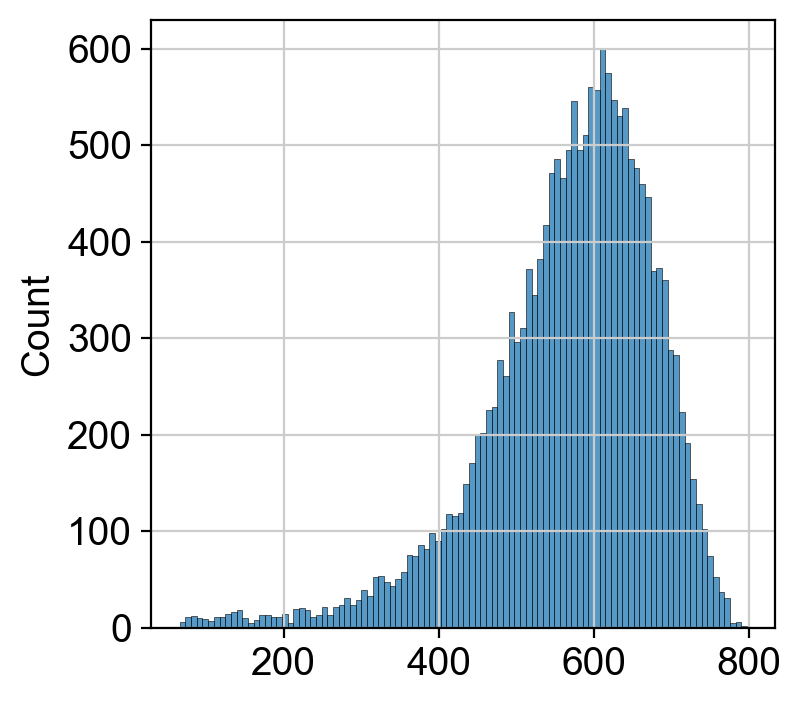

In [76]:
sns.histplot(sum_counts(fdataf.X, axis=1), bins = 100)

In [82]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy import sparse

def simulate_single_cells(
    ref,
    query,
    N,
    dist='sc-direct',
    sc_assay_name='counts',
    bulk_assay_name='counts',
    bulk_feature_row='gene_short_name'
):
    """
    Simulates N single cells for every bulk dataset case in `ref`,
    using the count distribution from `query`.
    
    Parameters:
    - ref (AnnData): The bulk reference AnnData object.
    - query (AnnData): The single-cell query AnnData object.
    - N (int): Number of single cells to generate per sample in `ref`.
    - dist (str): Distribution to use for generating total counts ('sc-model' or 'sc-direct').
    - sc_assay_name (str): Name of the layer in `query` containing scRNA-seq counts.
    - bulk_feature_row (str): Column name in `ref.var` containing gene identifiers.
    
    Returns:
    - expanded_adata (AnnData): An AnnData object with simulated single-cell data.
    """
    def get_counts_adata(adata, layer=None):
        """
        Retrieves the counts matrix from an AnnData object.
        If layer is specified, uses that layer; otherwise, uses adata.X.
        """
        if layer is not None:
            counts = adata.layers[layer]
        else:
            counts = adata.X
        return counts

    # Get counts from the query dataset
    counts_query = get_counts_adata(query, layer=sc_assay_name)
    if sparse.issparse(counts_query):
        sizes = counts_query.sum(axis=1).A1  # Convert to 1D array
    else:
        sizes = counts_query.sum(axis=1)
    # min_size = sizes.min()
    # max_size = sizes.max()
    
    # Number of single cells to generate
    ss_cells = N * ref.shape[0]
    
    # Generate total counts for downsampled cells
    if dist == "sc-model":
        print("Modeling count distribution of query using Empirical CDF")
        # Sort sizes to create the CDF
        sorted_sizes = np.sort(sizes)
        cdf = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
        # Draw random samples from a uniform distribution
        uniform_samples = np.random.rand(ss_cells)
        # Use inverse transform sampling to get values that match the empirical CDF
        final_newsizes = np.interp(uniform_samples, cdf, sorted_sizes).astype(int)
    else:
        # Use the direct sampling approach for "sc-direct"
        final_newsizes = np.random.choice(sizes, ss_cells, replace=True).astype(int)
    
    print("Finding common features between ref and query")
    genes_query = query.var_names
    genes_ref = ref.var[bulk_feature_row].values
    universe = np.intersect1d(genes_ref, genes_query)
    
    if len(universe) == 0:
        raise ValueError("No common genes found between ref and query.")
    
    print(f"Simulating {N} single cells for every bulk dataset case")
    
    # Prepare the reference counts data
    counts_ref_full = get_counts_adata(ref, layer=bulk_assay_name)
    if sparse.issparse(counts_ref_full):
        counts_ref_full = counts_ref_full.todense()
    counts_ref_full = pd.DataFrame(
        counts_ref_full.T,
        index=ref.var_names,
        columns=ref.obs_names
    )
    # Ensure genes_ref are aligned with counts_ref_full
    counts_ref_full = counts_ref_full.loc[genes_ref]
    # Keep only the common genes
    counts_ref_full = counts_ref_full.loc[universe]
    # Create an AnnData object with the filtered counts
    fdata = ad.AnnData(counts_ref_full.T)
    fdata.obs = ref.obs.copy()
    
    # Ensure the number of cells matches
    assert ss_cells == fdata.n_obs * N, "Mismatch in the number of single cells to generate."
    
    # Define the downsampling function
    def downsample_counts_vectorized(counts_matrix, new_total_counts):
        """
        Downsamples counts for multiple cells using vectorized multinomial sampling.
        """
        # Compute total counts per cell
        original_total_counts = counts_matrix.sum(axis=1)
        # Avoid division by zero
        nonzero_mask = original_total_counts > 0
        # Compute probabilities
        probabilities = np.zeros_like(counts_matrix, dtype=float)
        probabilities[nonzero_mask] = (
            counts_matrix[nonzero_mask] /
            original_total_counts[nonzero_mask, np.newaxis]
        )
        # Initialize the random number generator
        rng = np.random.default_rng()
        # Prepare an array to hold the downsampled counts
        downsampled_counts = np.zeros_like(counts_matrix, dtype=int)
        # Perform multinomial sampling where valid
        valid_mask = nonzero_mask & (new_total_counts > 0)
        if np.any(valid_mask):
            downsampled_counts[valid_mask] = rng.multinomial(
                n=new_total_counts[valid_mask],
                pvals=probabilities[valid_mask]
            )
        return downsampled_counts

    # Define the expand function
    def expand_anndata(adata, fold=10, total_counts_vector=None):
        """
        Expands an AnnData object by downsampling counts using vectorized sampling.
        The `obs` DataFrame is similarly expanded.
        """
        # Convert counts to dense matrix if sparse
        if sparse.issparse(adata.X):
            original_counts = adata.X.toarray()
        else:
            original_counts = adata.X.copy()
        
        num_cells, num_genes = original_counts.shape
        
        # Validate the total_counts_vector
        if total_counts_vector is not None:
            expected_length = num_cells * fold
            if len(total_counts_vector) != expected_length:
                raise ValueError(
                    f"The length of total_counts_vector ({len(total_counts_vector)}) "
                    f"must be equal to the number of expanded cells ({expected_length})."
                )
            new_total_counts = np.maximum(np.array(total_counts_vector, dtype=int), 0)
        else:
            # Use the original total counts repeated `fold` times
            original_total_counts = original_counts.sum(axis=1)
            new_total_counts = np.tile(original_total_counts, fold)
        
        # Expand counts by repeating each cell `fold` times
        expanded_counts = np.repeat(original_counts, fold, axis=0)
        
        # Downsample counts using vectorized multinomial sampling
        downsampled_counts = downsample_counts_vectorized(expanded_counts, new_total_counts)
        
        # Expand the obs DataFrame
        expanded_obs = pd.DataFrame(
            np.repeat(adata.obs.values, fold, axis=0),
            columns=adata.obs.columns
        )
        
        # Generate replicate numbers and new observation names
        replicate_numbers = np.tile(np.arange(1, fold + 1), num_cells)
        repeated_indices = np.repeat(adata.obs_names.values, fold)
        expanded_obs_names = [
            f"{obs}_rep{rep}" for obs, rep in zip(repeated_indices, replicate_numbers)
        ]
        expanded_obs.index = expanded_obs_names
        
        # Create a new AnnData object with the downsampled counts and expanded obs
        expanded_adata = ad.AnnData(
            X=sparse.csr_matrix(downsampled_counts),
            obs=expanded_obs,
            var=adata.var.copy()
        )
        
        return expanded_adata
    
    # Expand the data
    expanded_adata = expand_anndata(
        fdata,
        fold=N,
        total_counts_vector=final_newsizes
    )
    
    return expanded_adata


In [83]:
fdata = simulate_single_cells(rdata, adata, 6, "sc-direct", sc_assay_name="matrix")

Finding common features between ref and query
Simulating 6 single cells for every bulk dataset case


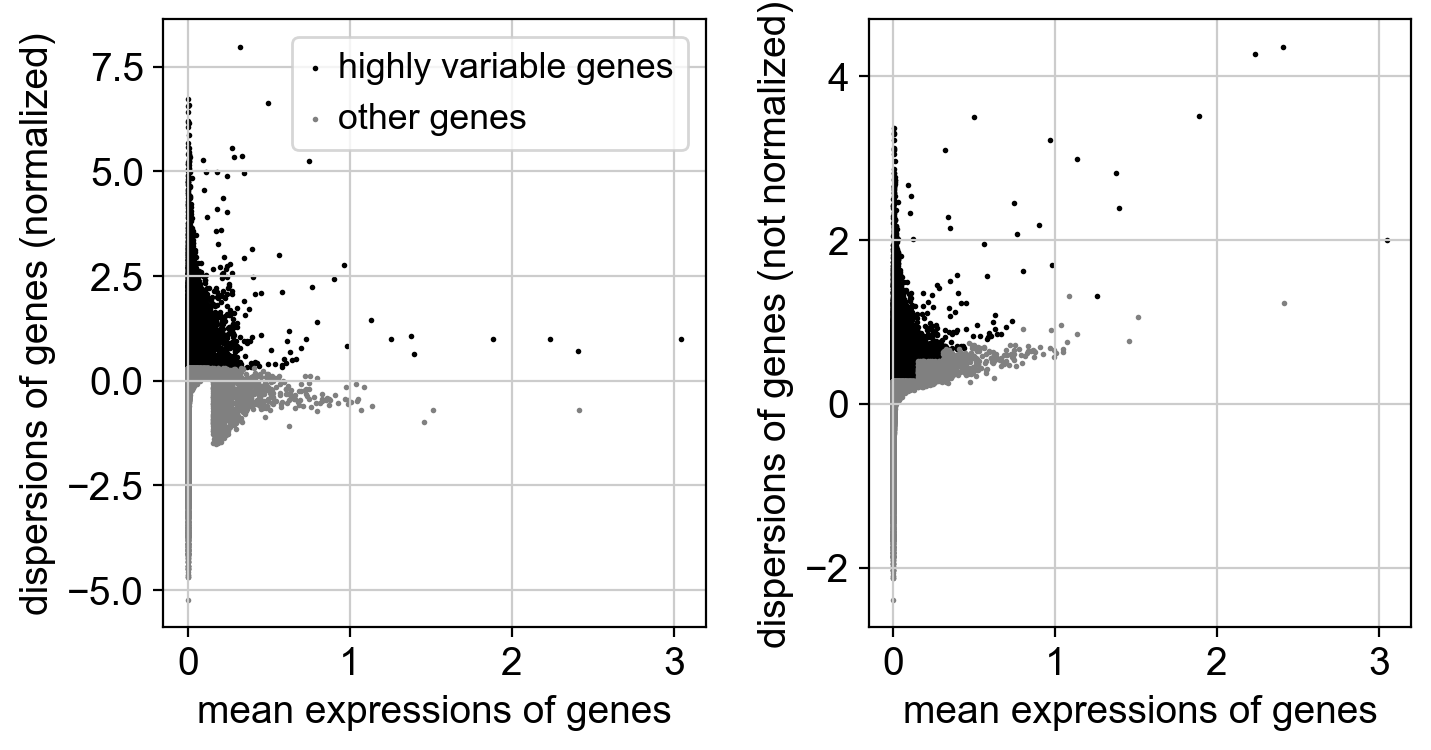

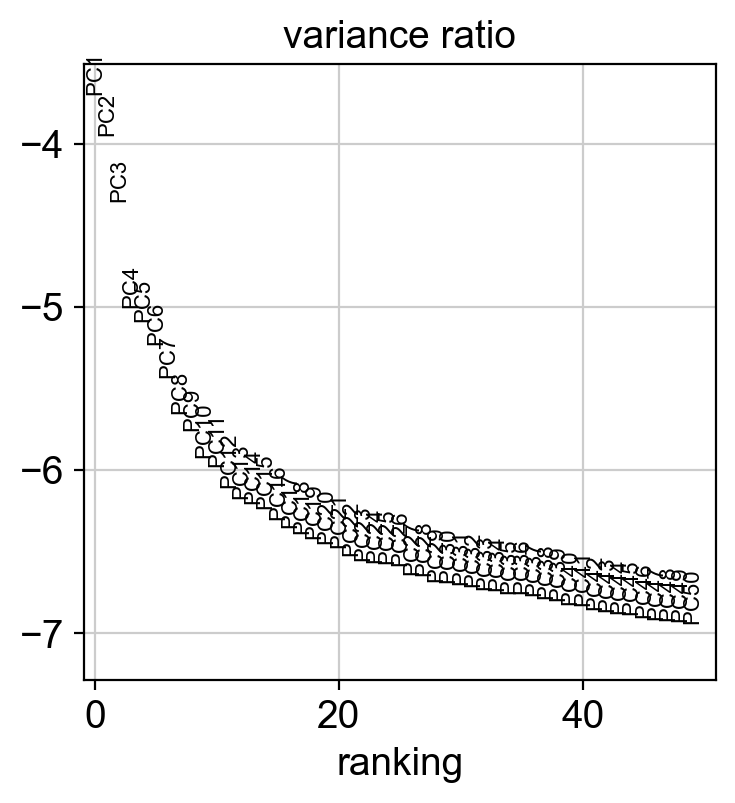

In [84]:
sc.pp.normalize_total(fdata)
sc.pp.log1p(fdata)
sc.pp.highly_variable_genes(fdata, n_top_genes=10000)
sc.pl.highly_variable_genes(fdata)
sc.tl.pca(fdata, n_comps=50)
sc.pl.pca_variance_ratio(fdata, n_pcs=50, log=True)

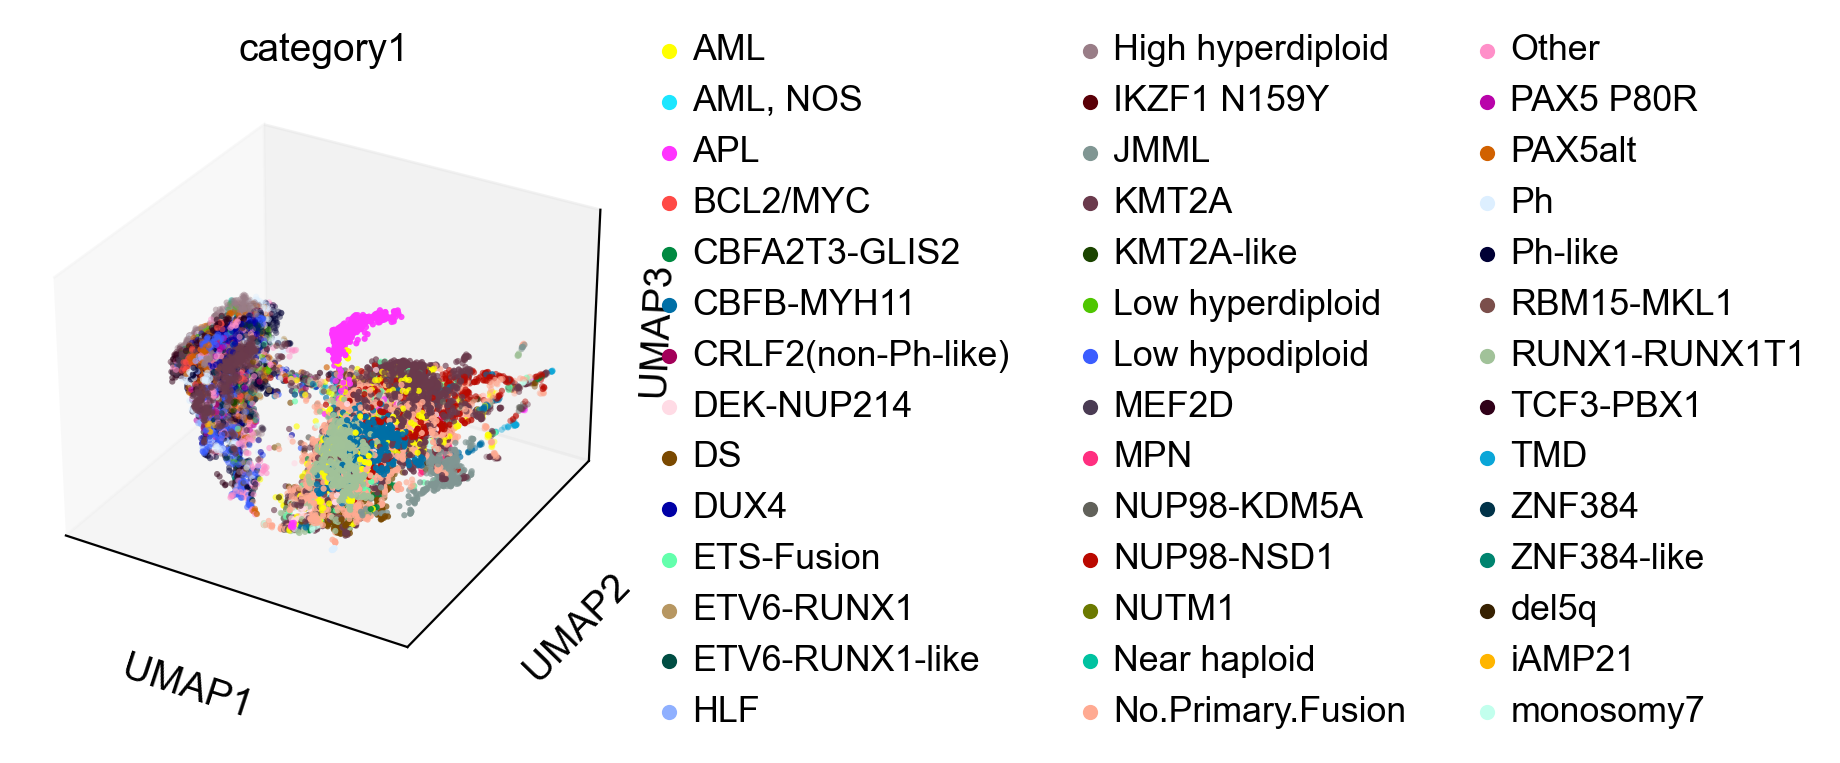

In [85]:
sc.pp.neighbors(fdataf, n_pcs=50)
sc.tl.umap(fdataf, min_dist=0.4, n_components=3)
sc.pl.umap(fdataf, color = "category1", projection = "3d")

In [86]:
viewmaster(query_cds=adata, ref_cds=fdata, ref_celldata_col="category1")

Preparing data...
Normalizing data...
Predictions added to query_cds.obs['viewmaster_pred']


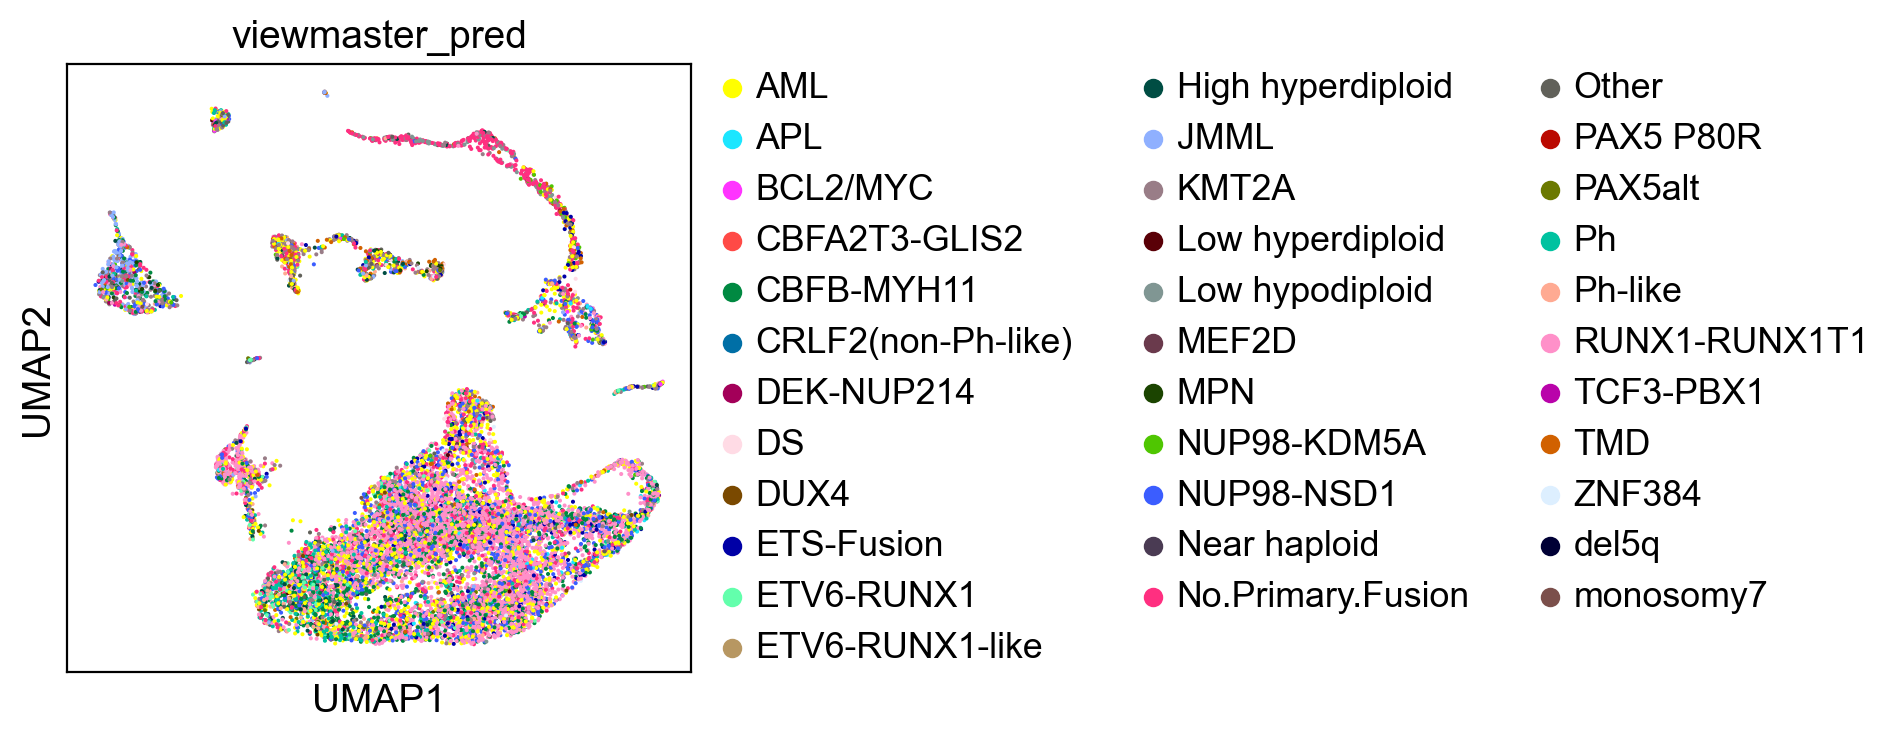

In [87]:
sc.pl.umap(query, color = "viewmaster_pred")

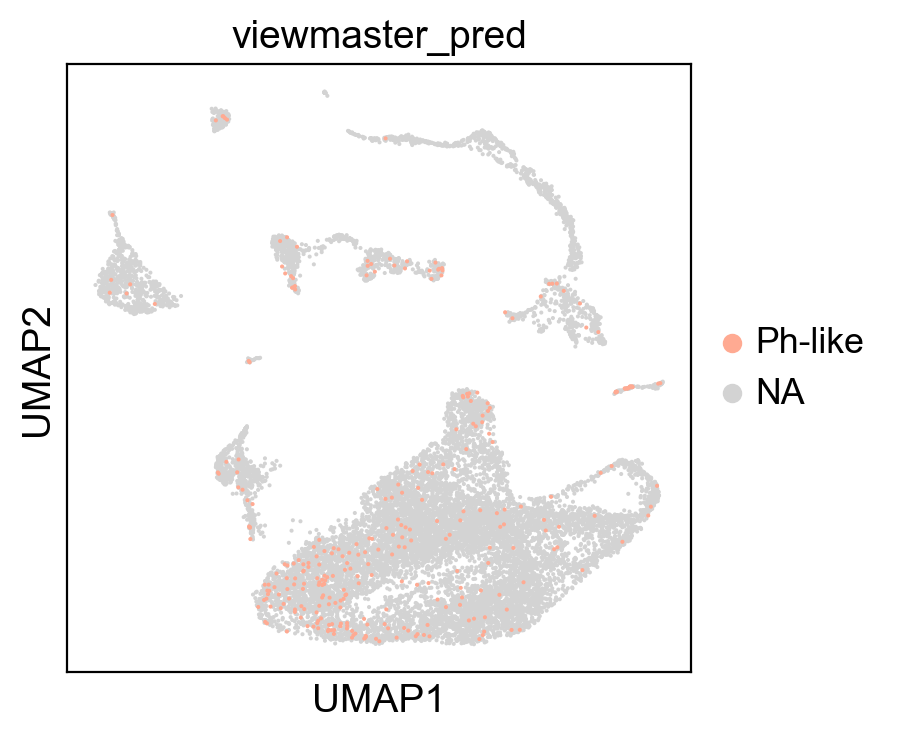

In [91]:
sc.pl.umap(query, color = "viewmaster_pred", groups = "Ph-like")